In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm.notebook import tqdm
from torch.optim import Adam

In [5]:
# normalize cifar-10 values to [-1, 1]
 # use 0.5 as std and mean, because ToTensor converts PIL values to [0, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
# Load CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

100%|███████████████████████████████████████████████████████████████| 170498071/170498071 [00:26<00:00, 6410325.34it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


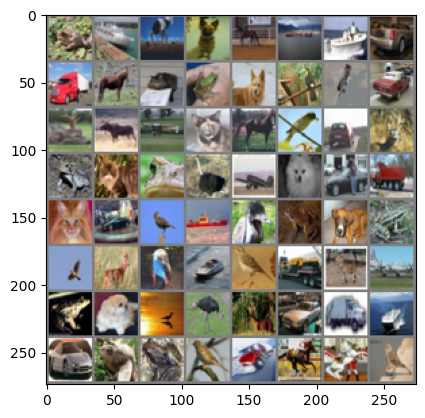

In [7]:
# Display some example images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize, comment if not using normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


In [8]:
# 2.1 Implement the Encoder for the VAE

class Encoder(nn.Module):
    def __init__(self, z=1):
        super().__init__()
        self.z = z # latent space dimension

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)  # 32x32x3 -> 16x16x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 16x16x32 -> 8x8x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # 8x8x64 -> 4x4x128
        self.relu = nn.ReLU()
        self.lin_m = nn.Linear(128 * 4 * 4, z)  # Mean of latent
        self.lin_s = nn.Linear(128 * 4 * 4, z)  # standard deviation

    def forward(self, inp):
        out = self.conv1(inp)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = out.reshape(inp.shape[0], -1) # flatten the tensor; change it to batch_size, num_features to make it applicable for the linear layer

        return self.lin_m(out), self.lin_s(out)  # Return mean and standard deviation

In [9]:
# 2.2 Implement the Decoder for the VAE

class Decoder(nn.Module):
    def __init__(self, z):
        super().__init__()

        self.conv2d1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # 4x4x128 -> 8x8x64
        self.conv2d2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # 8x8x64 -> 16x16x32
        self.conv2d3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)    # 16x16x32 -> 32x32x3
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()  # to normalize the output image in range [-1, 1]
        self.lin1 = nn.Linear(z, 128 * 4 * 4)  # 

    def forward(self, z):
        out = self.lin1(z)
        out = out.reshape(z.shape[0], 128, 4, 4)
        out = self.conv2d1(out)
        out = self.relu(out)
        out = self.conv2d2(out)
        out = self.relu(out)
        out = self.conv2d3(out)
        out = self.tanh(out)

        return out

In [10]:
class Variationautoencoder(nn.Module):
    def __init__(self, z):
        super().__init__()
        self.z = z
        self.encoder = Encoder(z)
        self.decoder = Decoder(z)

    def forward(self, X):
        m, s = self.encoder(X)
        # reparameterization trick
        # sample z = \mu + \epsilon*\sigma
        # z_norm is a batch of ϵ values with vectors of size 2 for each input of the batch
        z_norm = torch.randn(m.shape[0], self.z) # generate epsilon; shape[0] equals batch size, 2 is size of latent space defined by encoder output
        z = m + z_norm*s
        x_hat = self.decoder(z.unsqueeze(1))

        return x_hat, m, s # we need \mu and \sigma to compute loss

In [11]:
# 3. Define the loss function (VAE loss = reconstruction loss + KL divergence)
criterion = nn.MSELoss(reduction='sum') # mean squared errors loss function (common for regression), penalizes larger errors more than smaller ones

# from exercise 6
def kl_div(m, s):
    epsilon = 1e-8
    return torch.sum(0.5*(m**2 + s**2 - 1 - torch.log(s**2 + epsilon)), dim=1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = Variationautoencoder(z=128).to(device) # create VAE with latent dimensions of 128
optimizer = Adam(vae.parameters(), lr=0.001)

  0%|          | 0/10 [00:00<?, ?it/s]

Loss at the end of epoch 0: 12802.895643307425


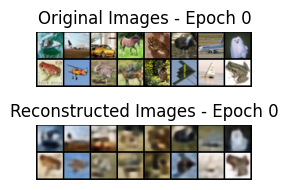

Loss at the end of epoch 1: 7077.398548175002


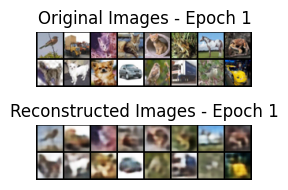

Loss at the end of epoch 2: 5858.560195337476


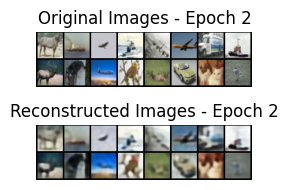

Loss at the end of epoch 3: 5205.0546821925955


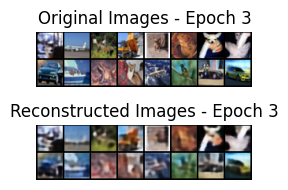

Loss at the end of epoch 4: 4817.835213039232


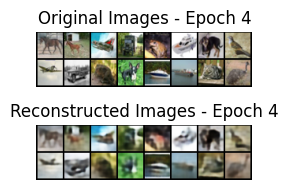

Loss at the end of epoch 5: 4577.3256436321135


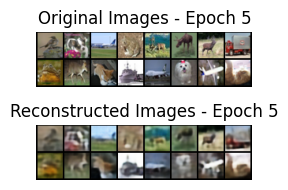

Loss at the end of epoch 6: 4415.3870651362195


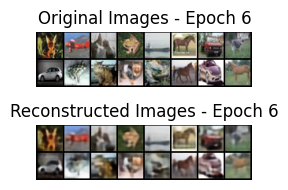

Loss at the end of epoch 7: 4314.804580103101


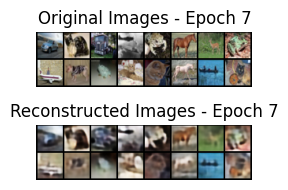

Loss at the end of epoch 8: 4249.393117607097


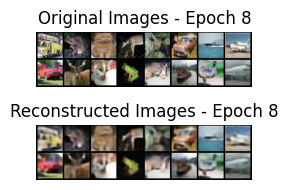

Loss at the end of epoch 9: 4203.053861886339


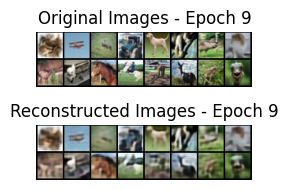

In [13]:
# 4. Training the VAE
epochs = 10
for e in tqdm(range(epochs)):
    vae.train()
    running_loss = 0
    batches = 0
    for X, label in trainloader:
        batches+=1
        X = X.to(device)
        X_hat, m, s = vae(X)
        loss = criterion(X_hat, X) + torch.mean(kl_div(m, s))
        optimizer.zero_grad()
        loss.backward()
        running_loss+=loss.detach().item()
        optimizer.step()
    print(f"Loss at the end of epoch {e}: {running_loss/batches}")

    vae.eval()
    with torch.no_grad():
        dataiter = iter(trainloader)
        images, _ = next(dataiter)
        images = images.to(device)
        recon_images, _, _ = vae(images)

        # Move tensors to CPU for visualization, matplotlib might raise errors if images are on GPU
        images = images.cpu()
        recon_images = recon_images.cpu()

        # Create a grid for original and reconstructed images
        fig, axes = plt.subplots(2, 1, figsize=(8, 2))
        axes[0].imshow(torchvision.utils.make_grid(images[:16], normalize=True).permute(1, 2, 0))
        axes[0].set_title(f"Original Images - Epoch {e}")
        axes[0].axis("off")

        axes[1].imshow(torchvision.utils.make_grid(recon_images[:16], normalize=True).permute(1, 2, 0))
        axes[1].set_title(f"Reconstructed Images - Epoch {e}")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

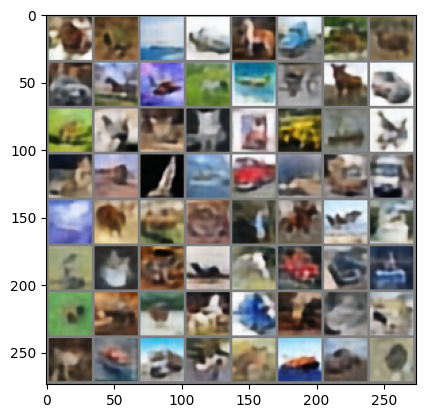

In [15]:
# 5. Visualizing results (reconstructed images)
vae.eval()
with torch.no_grad():
    dataiter = iter(trainloader)
    images, _ = next(dataiter)
    images = images.to(device)
    recon_images, _, _ = vae(images)
    imshow(torchvision.utils.make_grid(recon_images.cpu()))
